Després de veure els resultats dels models sense features, ara toca experimentar amb quins features i quina codificació fan que el model millori.
En aquesta versió, afegim embeddings de paraules utilitzant Word2Vec per obtenir un millor context semàntic.

In [59]:
#%pip install gensim

In [66]:
import nltk
import re
import unicodedata
import numpy as np
from nltk.tag import CRFTagger
from gensim.models import FastText
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

nltk.download('conll2002')
nltk.download('stopwords')
from nltk.corpus import conll2002, stopwords

tr_sp = conll2002.iob_sents('esp.train') # Train Español
dev_sp = conll2002.iob_sents('esp.testa') # Dev Español
test_sp = conll2002.iob_sents('esp.testb') # Test Español

stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
# Transformar los datos: dejar solo (palabra, NER)
train_sents = [[(word, ner) for word, pos, ner in sent] for sent in tr_sp]
test_sents = [[(word, ner) for word, pos, ner in sent] for sent in test_sp]

In [83]:
word_sentences = [[token for token, _ in sentence] for sentence in train_sents]
    
model = FastText(
    sentences=word_sentences,
    vector_size=300,       
    window=10,              
    min_count=1,          
    workers=4,            
    sg=1,                  
    min_n=3,              
    max_n=6                
)


In [84]:
words = list(model.wv.index_to_key)
word_vectors = [model.wv[word] for word in words]

# Aplicar K-means
kmeans = KMeans(n_clusters=300, random_state=42)
clusters = kmeans.fit_predict(word_vectors)

In [87]:
word_to_cluster = {word: cluster_id for word, cluster_id in zip(words, clusters)}

cluster_id_deseado = 243


palabras_del_cluster = [word for word, cid in word_to_cluster.items() if cid == cluster_id_deseado]

print(f"Palabras en el clúster {cluster_id_deseado}:")
for palabra in palabras_del_cluster:
    print(palabra)


Palabras en el clúster 243:
Barcelona
Brasil
Santiago
Chile
Sevilla
Río
Nueva
Italia
Cantabria
Bilbao
Sebastián
Janeiro
York
Cádiz
Pamplona
Zaragoza
Palma
Washington
Vitoria
Paulo
Lisboa
fotografía
Girona
Sao
despejado
Compostela
Melilla
Valladolid
Fráncfort
Vizcaya
Coruña
Beirut
Guadalajara
Berlín
Panamá
Padua
Pontevedra
Tarragona
EFE-Cantabria
Montevideo
Lilia
Nuboso
Corona
Brasilia
Badalona
Vela
Sebastiao
Lig
Port
Mellia
Merce
Malon
Sanabria


In [86]:
new_word = "Barcelona"  # Palabra que no estaba en train_sents

# Obtener embedding (aunque la palabra sea nueva)
new_word_vector = model.wv[new_word]  # Usa subwords para aproximar el embedding

# Predecir clúster
cluster = kmeans.predict([new_word_vector])[0]
print(f"La palabra '{new_word}' pertenece al clúster {cluster}")
print(type(cluster))

La palabra 'Barcelona' pertenece al clúster 243
<class 'numpy.int32'>


In [88]:
def features(tokens, idx):
    """
    Extrae características de una palabra, incluyendo:
        - Capitalización
        - Prefijos y sufijos
        - Tokens anteriores y posteriores
        - Embedding de palabra utilizando Word2Vec
    """
    pattern = re.compile(r"\d")
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    # Capitalización
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Número
    if re.search(pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Puntuación
    punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Prefijos y sufijos
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
        feature_list.append("PREF_" + token[:1])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
        feature_list.append("PREF_" + token[:2])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        feature_list.append("PREF_" + token[:3])

    # Palabra anterior
    if idx > 0:
        prev_token = tokens[idx - 1]
        feature_list.append("PREV_WORD_" + prev_token)
    else:
        feature_list.append("BOS")  # Inicio de oración

    # Palabra siguiente
    if idx < len(tokens) - 1:
        next_token = tokens[idx + 1]
        feature_list.append("NEXT_WORD_" + next_token)
    else:
        feature_list.append("EOS")  # Fin de oración

    word_vect = model.wv[token]  # Usa subwords para aproximar el embedding

    # Predecir clúster
    cluster = kmeans.predict([word_vect])[0]

    feature_list.append("CLUSTER_" + str(cluster))

    feature_list.append("WORD_" + token)

    return feature_list

In [89]:
ct = nltk.tag.CRFTagger(feature_func=features)
ct.train(train_sents, 'esp_model.crf.tagger')
ct.set_model_file('esp_model.crf.tagger')

In [90]:
predicted_sents = ct.tag_sents([ [word for word, tag in sent] for sent in test_sents ])

In [91]:
# Accuracy a nivel de entidades, reemplazado por F1-Score
from sklearn.metrics import classification_report

true_entities = []
predicted_entities = []

for true_sent, pred_sent in zip(test_sents, predicted_sents):
    for (word_t, tag_t), (word_p, tag_p) in zip(true_sent, pred_sent):
        if tag_t != 'O':  # <- Aquí filtrem les paraules que són entitats en el conjunt de test
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)
        elif tag_p != 'O' and tag_t == 'O': # <- Tmb agafem les entitats que el model prediu com entitats pero no ho són.
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)

# Generar informe de clasificación
print("Classification Report:")
print(classification_report(true_entities, predicted_entities, digits=4))

Classification Report:
              precision    recall  f1-score   support

       B-LOC     0.7998    0.7408    0.7692      1084
      B-MISC     0.6603    0.5103    0.5757       339
       B-ORG     0.8106    0.8436    0.8267      1400
       B-PER     0.8382    0.8531    0.8456       735
       I-LOC     0.7003    0.6185    0.6569       325
      I-MISC     0.5938    0.5853    0.5895       557
       I-ORG     0.8248    0.7844    0.8041      1104
       I-PER     0.8770    0.9338    0.9045       634
           O     0.0000    0.0000    0.0000       212

    accuracy                         0.7463      6390
   macro avg     0.6783    0.6522    0.6636      6390
weighted avg     0.7616    0.7463    0.7529      6390



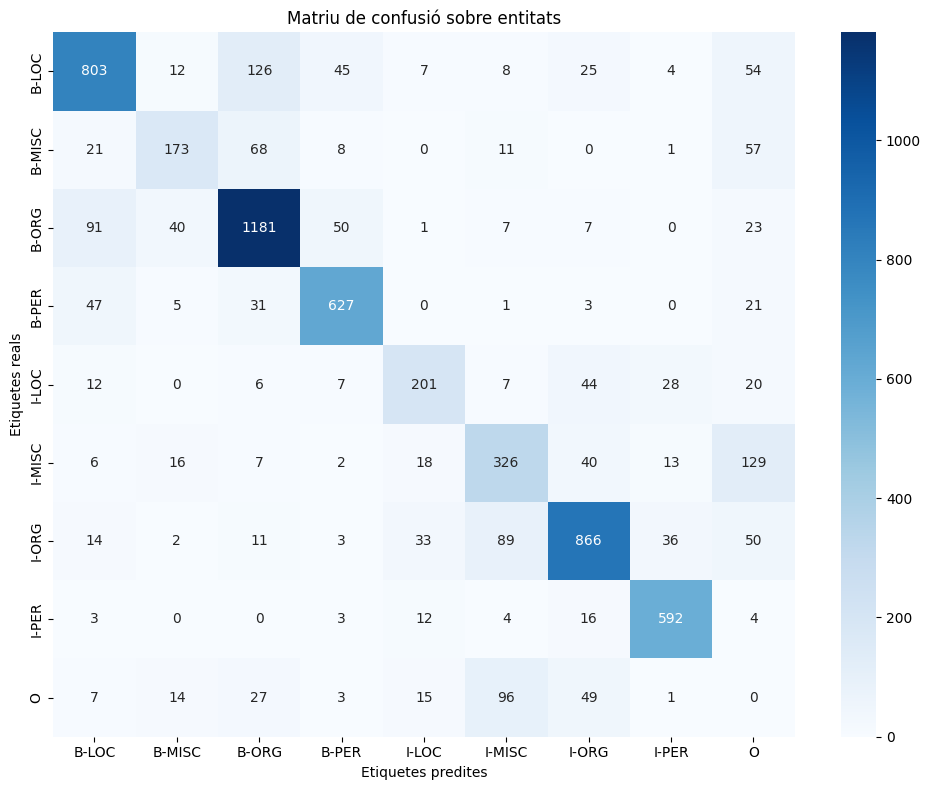

In [92]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(set(true_entities + predicted_entities))

cm = confusion_matrix(true_entities, predicted_entities, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Etiquetes predites')
plt.ylabel('Etiquetes reals')
plt.title('Matriu de confusió sobre entitats')
plt.tight_layout()
plt.show()